[IPython Notebook](legacy.ipynb) |  [Python Script](legacy.py)

Comparing PHOEBE 2.0 vs PHOEBE Legacy
============================

**NOTE**: PHOEBE 1.0 legacy is an alternate backend and is not installed with PHOEBE 2.0.  In order to run this backend, you'll need to have [PHOEBE 1.0](https://phoebe-project.org/1.0) installed.

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.html) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='INFO')

b = phoebe.Bundle.default_binary()
b['q'] = 0.7

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/usr/local/lib/python2.7/dist-packages/astropy/units/quantity.py:732: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__eq__(other)


Adding Datasets and Compute Options
--------------------

In [3]:
b.add_dataset('LC', time=np.linspace(0,3,101), dataset='lc01')
b.add_dataset('RV', time=np.linspace(0,3,101), dataset='rvdyn')
b.add_dataset('RV', time=np.linspace(0,3,101), dataset='rvnum')

<ParameterSet: 24 parameters | methods: RV, RV_dep>

Let's add compute options for phoebe using both the new (marching) method for creating meshes as well as the WD method which imitates the format of the mesh used within legacy.

In [4]:
b.add_compute(compute='phoebe2marching', mesh_method='marching')

<ParameterSet: 18 parameters | qualifiers: dynamics_method, gridsize, stepsize, lc_method, atm, enabled, ltte, rv_grav, orbiterror, rv_method, etv_method, maxpoints, delta, etv_tol, store_mesh, distortion_method, eclipse_alg, mesh_method>

In [5]:
b.add_compute(compute='phoebe2wd', mesh_method='wd', eclipse_alg='graham')

<ParameterSet: 18 parameters | qualifiers: dynamics_method, gridsize, stepsize, lc_method, atm, enabled, ltte, rv_grav, orbiterror, rv_method, etv_method, maxpoints, delta, etv_tol, store_mesh, distortion_method, eclipse_alg, mesh_method>

Now we add compute options for the 'legacy' backend.

In [6]:
b.add_compute('legacy', compute='phoebe1')

<ParameterSet: 11 parameters | qualifiers: atm, refl_num, cindex, store_mesh, enabled, heating, rv_method, gridsize, morphology, mult_refl, ie>

And set the two RV datasets to use the correct methods (for both compute options)

In [7]:
b.set_value_all('rv_method', dataset='rvdyn', value='dynamical')

In [8]:
b.set_value_all('rv_method', dataset='rvnum', value='flux-weighted')

The 'blackbody' atmospheres from phoebe1 are comperable to the 'extern_planckint' atmospheres in phoebe.

In [9]:
b.set_value_all('atm@phoebe2wd', 'extern_planckint')
b.set_value_all('atm@phoebe2marching', 'extern_planckint')
b.set_value_all('atm@phoebe1', 'blackbody')

Let's make sure both 'phoebe1' and 'phoebe2wd' use the same value for gridsize

In [10]:
b.set_value_all('gridsize', 30)

In [11]:
# TODO: remove this once subdivision is either re-supported or removed entirely
b.set_value_all('subdiv_num', 0)

Let's also disable other special effect such as heating, gravity, and light-time effects.

In [12]:
b.set_value_all('ld_coeffs', [0.,0.])
# TODO: remove this once tested to work correctly with limbdarkening

In [13]:
b.set_value_all('heating', False)
#b.set_value_all('refl', False)
# TODO: remove these?

In [14]:
b.set_value_all('rv_grav', False)
# TODO: phoebe1???
# TODO: remove these?

In [15]:
b.set_value_all('ltte', False)

Finally, let's compute all of our models

In [16]:
b.run_compute(compute='phoebe2marching', model='phoebe2marchingmodel')

<ParameterSet: 10 parameters | methods: RV, LC>

In [17]:
b.run_compute(compute='phoebe2wd', model='phoebe2wdmodel')

/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:12: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:12: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:12: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:12: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:12: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  hull, ins

<ParameterSet: 10 parameters | methods: RV, LC>

In [18]:
b.run_compute(compute='phoebe1', model='phoebe1model')

<ParameterSet: 10 parameters | methods: RV, LC>

Plotting
-------------------------

### Light Curve

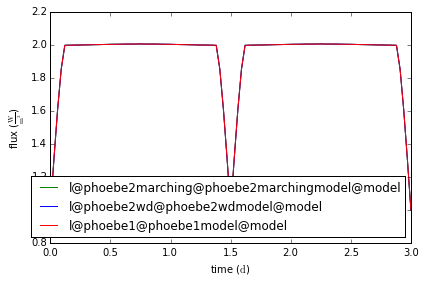

In [19]:
axs, artists = b['lc01@phoebe2marchingmodel'].plot(color='g')
axs, artists = b['lc01@phoebe2wdmodel'].plot(color='b')
axs, artists = b['lc01@phoebe1model'].plot(color='r')
leg = plt.legend(loc=4)

Now let's plot the residuals between these two models

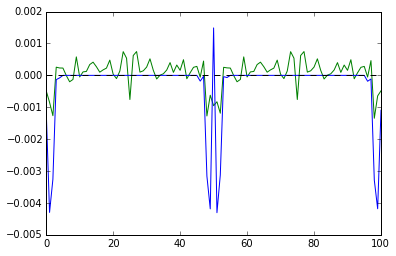

In [20]:
artist, = plt.plot(b.get_value('flux@lc01@phoebe2marchingmodel') - b.get_value('flux@lc01@phoebe1model'), 'g-')
artist, = plt.plot(b.get_value('flux@lc01@phoebe2wdmodel') - b.get_value('flux@lc01@phoebe1model'), 'b-')
artist = plt.axhline(0.0, linestyle='dashed', color='k')


### Dynamical RVs

Since the dynamical RVs don't depend on the mesh, there should be no difference between the 'phoebe2marching' and 'phoebe2wd' synthetic models.  Here we'll just choose one to plot.

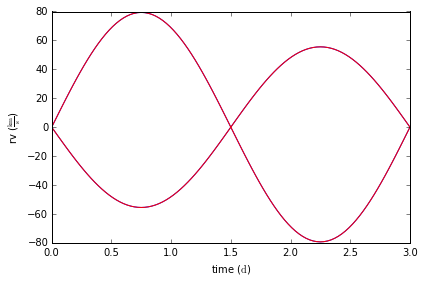

In [21]:
axs, artists = b['rvdyn@phoebe2wdmodel'].plot(color='b')
axs, artists = b['rvdyn@phoebe1model'].plot(color='r')

And also plot the residuals of both the primary and secondary RVs (notice the scale on the y-axis)

(-1e-12, 1e-12)

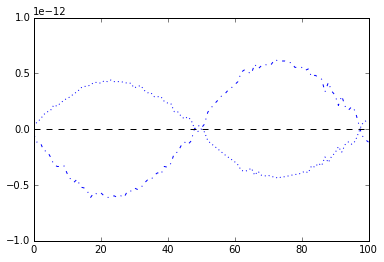

In [22]:
artist, = plt.plot(b.get_value('rv@rvdyn@primary@phoebe2wdmodel') - b.get_value('rv@rvdyn@primary@phoebe1model'), color='b', ls=':')
artist, = plt.plot(b.get_value('rv@rvdyn@secondary@phoebe2wdmodel') - b.get_value('rv@rvdyn@secondary@phoebe1model'), color='b', ls='-.')
artist = plt.axhline(0.0, linestyle='dashed', color='k')
plt.ylim(-1e-12, 1e-12)

### Numerical (flux-weighted) RVs

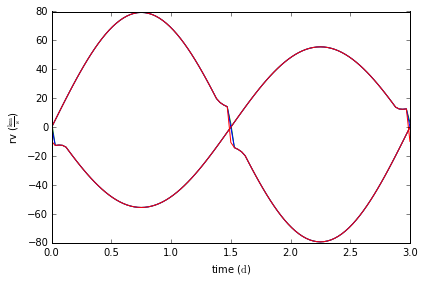

In [23]:
axs, artists = b['rvnum@phoebe2marchingmodel'].plot(color='g')
axs, artists = b['rvnum@phoebe2wdmodel'].plot(color='b')
axs, artists = b['rvnum@phoebe1model'].plot(color='r')

(-0.01, 0.01)

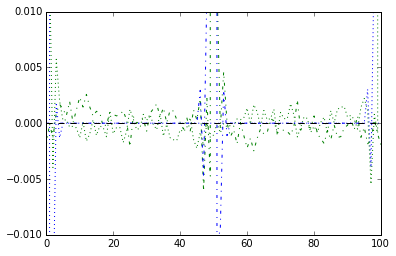

In [24]:
artist, = plt.plot(b.get_value('rv@rvnum@primary@phoebe2marchingmodel', ) - b.get_value('rv@rvnum@primary@phoebe1model'), color='g', ls=':')
artist, = plt.plot(b.get_value('rv@rvnum@secondary@phoebe2marchingmodel') - b.get_value('rv@rvnum@secondary@phoebe1model'), color='g', ls='-.')

artist, = plt.plot(b.get_value('rv@rvnum@primary@phoebe2wdmodel', ) - b.get_value('rv@rvnum@primary@phoebe1model'), color='b', ls=':')
artist, = plt.plot(b.get_value('rv@rvnum@secondary@phoebe2wdmodel') - b.get_value('rv@rvnum@secondary@phoebe1model'), color='b', ls='-.')

artist = plt.axhline(0.0, linestyle='dashed', color='k')
plt.ylim(-1e-2, 1e-2)